In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
from utils_evaluate_model import *

import random
from pathlib import Path
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import resize as tv_resize
from torch.nn.functional import pad as Fpad
import torchvision.transforms as T
from utils_ot import * 

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:1')
    torch.cuda.FloatTensor
elif torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda:1


1 variantes, 8 niveaux chacune.


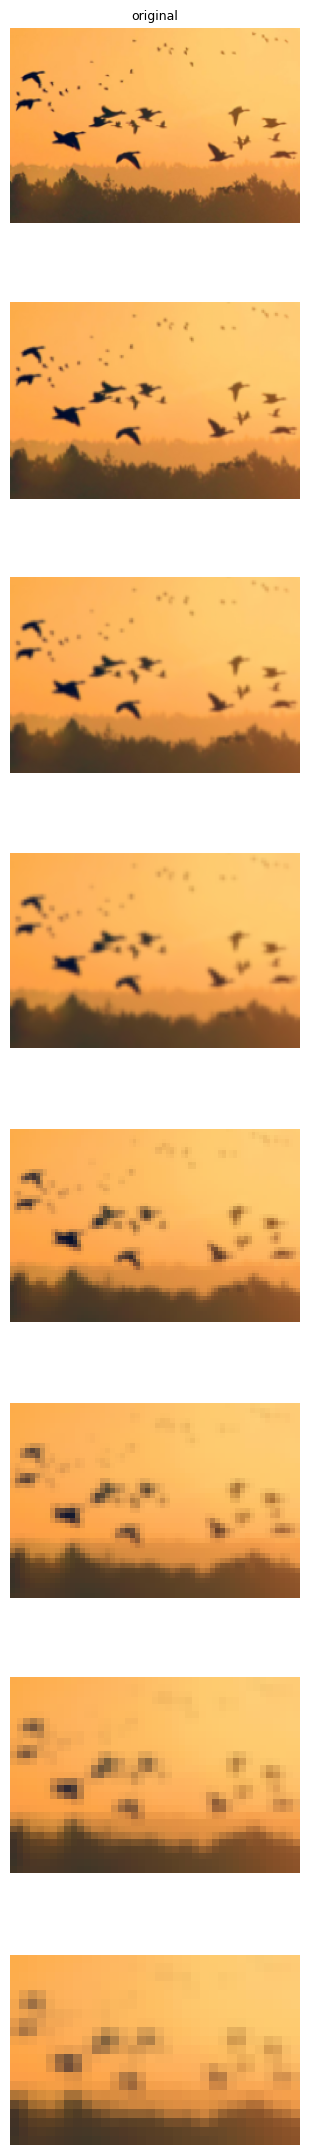

In [4]:
"""
SinGAN data-augmentation helper (torchvision.GaussianBlur)
──────────────────────────────────────────────────────────
• Produit l’image originale + N_AUG variantes aléatoires.
• Augmentations possibles :
      – pad réflectif + rotation aléatoire (sans bordures noires)
      – ColorJitter
• Chaque variante finit en 3×H×W, valeurs ∈ [-1, 1].
• Construit pour chacune la pyramide d’échelles façon SinGAN.
"""

IMG_PATH   = Path("images/birds.png")             # image de référence
MAX_DIM    = 250        # côté le plus long après resize initial
MIN_DIM    = 25         # côté mini à l’échelle la plus coarse
RATIO      = 4/3      # facteur de downscale entre niveaux

N_AUG      = 0          # nombre de variantes à générer
MAX_ROT    = 5         # rotation ±MAX_ROT°
PAD_RATIO  = 0.20       # pad(reflect) = PAD_RATIO × taille

JITTER     = dict(brightness=0.25,
                  contrast=0.25,
                  saturation=0.25,
                  hue=0.1)

SEED       = 1       # fixer pour reproductibilité

# ------------------------------------------------------------
# 2. Bloc d’augmentation
# ------------------------------------------------------------
class AugmentVariant(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.jitter  = T.ColorJitter(**JITTER)
        
    @torch.no_grad()
    def forward(self, x):
        # x : 3×H×W ∈ [-1,1]
        C, H, W = x.shape

        # Pad-Rotate-Crop (pas de bordures noires)
        ph, pw = int(H * PAD_RATIO), int(W * PAD_RATIO)
        x = Fpad(x, (pw, pw, ph, ph), mode="reflect")
        angle = random.uniform(-MAX_ROT, MAX_ROT)
        x = TF.rotate(x, angle, expand=False)
        x = TF.center_crop(x, (H, W))

        # ColorJitter
        x = self.jitter((x+1)/2) * 2 - 1

        return x.clamp(-1, 1)


torch.manual_seed(SEED) 
random.seed(SEED)

img   = Image.open(IMG_PATH).convert("RGB")
orig  = TF.to_tensor(img).to(device)                       # [0,1]
_, H0, W0 = orig.shape
scale = MAX_DIM / max(H0, W0)
orig  = tv_resize(orig, [int(H0*scale), int(W0*scale)], antialias=True)
orig  = orig * 2 - 1                            # [-1,1]


augmenter = AugmentVariant().to(device)
variants  = [orig] + [augmenter(orig.clone()) for _ in range(N_AUG)]

# ------------------------------------------------------------
# 5. Pyramides SinGAN
# ------------------------------------------------------------
def build_pyramid(img):
    levels = [img.unsqueeze(0)]              # fine → coarse (déjà sur device)
    while True:
        _, _, h, w = levels[-1].shape
        nh, nw = int(h / RATIO), int(w / RATIO)
        
        down = tv_resize(levels[-1], [nh, nw], antialias=True).to(device)  # <──
        levels.append(down)
        if nh < MIN_DIM or nw < MIN_DIM: break
    return levels

pyramids = [[lvl.to(device) for lvl in build_pyramid(v)] for v in variants]
print(f"{len(variants)} variantes, {len(pyramids[0])} niveaux chacune.")

# ------------------------------------------------------------
# 6. (Optionnel) Visualisation grille
# ------------------------------------------------------------
def show_grid(pyramids):
    rows, cols = len(pyramids[0]), len(pyramids)
    
    # Handle case with a single column (cols == 1) or multiple columns
    if cols == 1:
        fig, axes = plt.subplots(rows, 1, figsize=(3.2, 2.8 * rows))
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(3.2 * cols, 2.8 * rows))
    
    # In case of a single column, axes is a 1D array, not a 2D array
    for r in range(rows):
        for c in range(cols):
            # Handle the case where there's only one column (axes is not a 2D array)
            if cols == 1:
                ax = axes[r]
            else:
                ax = axes[r, c]
            
            # Process the image
            img_np = (pyramids[c][r].cpu().squeeze(0).permute(1, 2, 0) + 1) / 2
            ax.imshow(img_np.clamp(0, 1))
            
            # Set the title for the top row
            if r == 0:
                ax.set_title("original" if c == 0 else f"aug {c}", fontsize=9)
            
            # Hide the axis ticks
            ax.axis('off')
    
    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()

# Décommentez pour vérifier visuellement
show_grid(pyramids)


In [5]:
for x in pyramids[0] : 
    print(x.shape)
    print(x.device)

torch.Size([1, 3, 168, 249])
cuda:1
torch.Size([1, 3, 126, 186])
cuda:1
torch.Size([1, 3, 94, 139])
cuda:1
torch.Size([1, 3, 70, 104])
cuda:1
torch.Size([1, 3, 52, 78])
cuda:1
torch.Size([1, 3, 39, 58])
cuda:1
torch.Size([1, 3, 29, 43])
cuda:1
torch.Size([1, 3, 21, 32])
cuda:1


In [6]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

+ Générations des generateurs/discriminateurs

In [18]:
hidden_lowest_dim = 32
Genarators = []
N = len(pyramids[0])

for i in range(N):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device))
   
for gen in Genarators : 
     print(gen.n_hidden)



128
64
64
64
64
32
32
32


+ Boucle d'entrainement 

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




In [20]:
import math
import torch.nn as nn          # déjà importé plus haut normalement

# ----- progressivité des patches ------------------------------------------
PATCH_BASE     = [4, 8, 10, 20]   # mêmes proportions qu’avant
PATCH_GROWTH   = 1            # facteur (> 1) d’une échelle à l’autre
PATCH_MAX0     = 20               # max pour l’échelle coarse   (current_res = N-1)


def patch_table_for_scale(scale_idx: int):
    """
    Retourne (patch_sizes, strides) pour l’échelle `scale_idx`
    scale_idx == N-1 → patch_max = 20
    scale_idx == N-2 → patch_max = 20*(4/3)
    etc.
    """
    exp        = (N - 1) - scale_idx            # 0,1,2…
    patch_max  = int(round(PATCH_MAX0 * (PATCH_GROWTH ** exp)))
    sizes      = [int(round(p * patch_max / PATCH_MAX0)) for p in PATCH_BASE]
    strides    = [max(1, s // 2) for s in sizes]    # stride = patch//2
    return sizes, strides


[4, 8, 10, 20] [2, 4, 5, 10]


it scale 7:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 7 | it 0] 
[scale 7 | it 0]  σ = 9.999e-01

 mean lost 100 iter 4.2125

ratio_loss = 421250963.2111


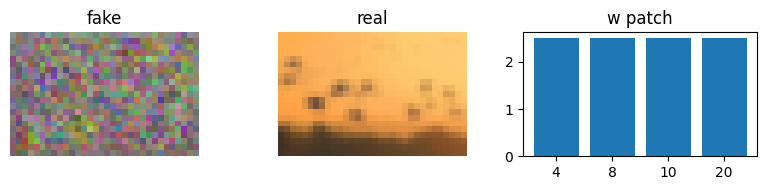

it scale 7:   0%|          | 1/2000 [00:00<04:48,  6.93it/s]

patch weights : [2.5 2.5 2.5 2.5]


it scale 7:  50%|█████     | 1000/2000 [00:15<00:15, 65.26it/s]

[scale 7 | it 1000] 
[scale 7 | it 1000]  σ = 9.955e-01

 mean lost 100 iter 0.6641

ratio_loss = 65584945.6787


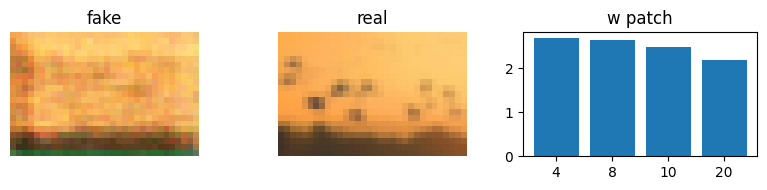

patch weights : [2.6822 2.6494 2.474  2.1944]


it scale 7: 100%|█████████▉| 1994/2000 [00:30<00:00, 83.29it/s]

[scale 7 | it 1999] 
[scale 7 | it 1999]  σ = 9.985e-01

 mean lost 100 iter 0.6135

ratio_loss = 59509217.7391


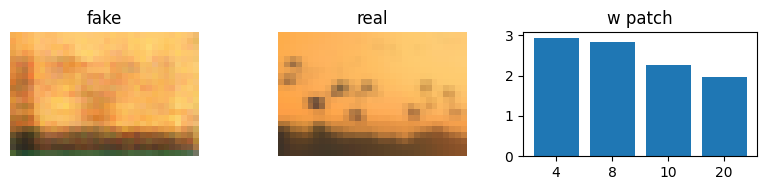

patch weights : [2.9301 2.8437 2.2573 1.9689]
STOOPING 


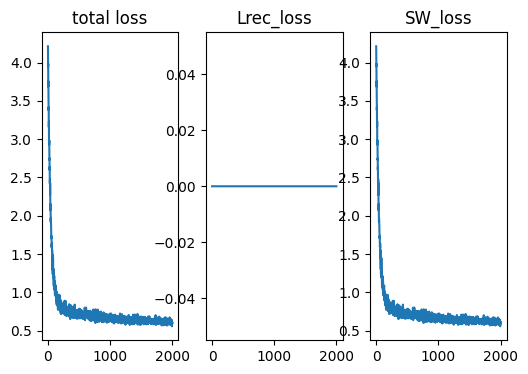

[4, 8, 10, 20] [2, 4, 5, 10]


it scale 6:   0%|          | 0/2300 [00:00<?, ?it/s]

[scale 6 | it 0] 
[scale 6 | it 0]  σ = 2.911e-02

 mean lost 100 iter 1.0847

ratio_loss = 108468079.5670


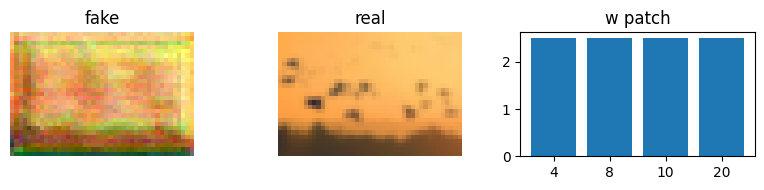

it scale 6:   0%|          | 1/2300 [00:00<05:20,  7.17it/s]

patch weights : [2.5 2.5 2.5 2.5]


it scale 6:  43%|████▎     | 996/2300 [00:15<00:22, 57.99it/s]

[scale 6 | it 1000] 
[scale 6 | it 1000]  σ = 2.757e-02

 mean lost 100 iter 0.4535

ratio_loss = 42844718.6947


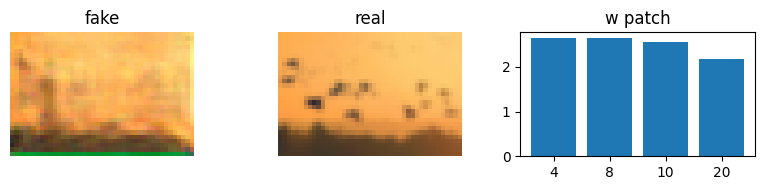

it scale 6:  44%|████▎     | 1002/2300 [00:15<00:31, 41.60it/s]

patch weights : [2.6388 2.6336 2.5533 2.1743]


it scale 6:  87%|████████▋ | 1997/2300 [00:31<00:04, 60.74it/s]

[scale 6 | it 2000] 
[scale 6 | it 2000]  σ = 2.599e-02

 mean lost 100 iter 0.4220

ratio_loss = 41676342.4873


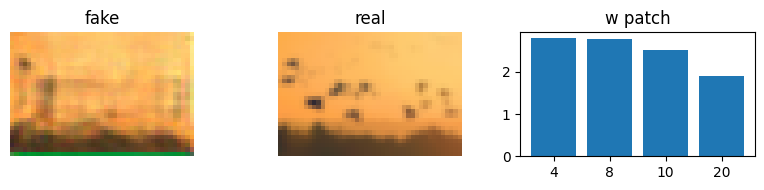

it scale 6:  87%|████████▋ | 2004/2300 [00:32<00:06, 45.58it/s]

patch weights : [2.8    2.7787 2.5166 1.9046]


it scale 6: 100%|█████████▉| 2294/2300 [00:36<00:00, 60.83it/s]

[scale 6 | it 2299] 
[scale 6 | it 2299]  σ = 2.548e-02

 mean lost 100 iter 0.4110

ratio_loss = 40998077.3926


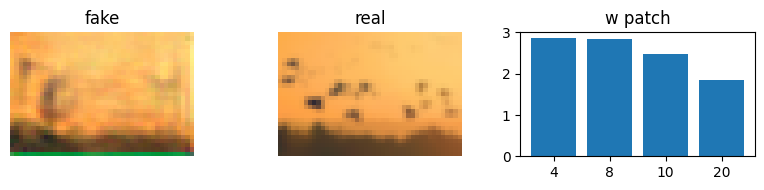

patch weights : [2.8606 2.832  2.4699 1.8375]
STOOPING 


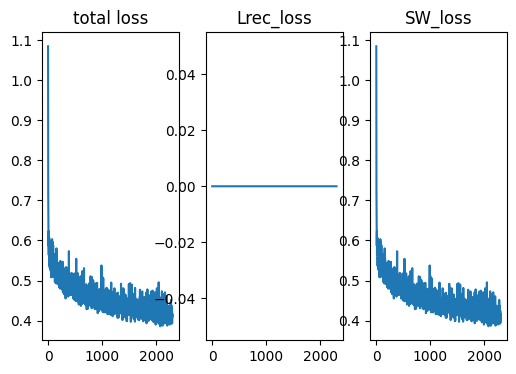

[4, 8, 10, 20] [2, 4, 5, 10]


it scale 5:   0%|          | 0/2600 [00:00<?, ?it/s]

[scale 5 | it 0] 
[scale 5 | it 0]  σ = 3.021e-02

 mean lost 100 iter 0.8440

ratio_loss = 84403264.5226


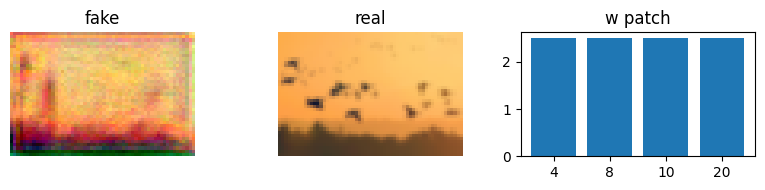

it scale 5:   0%|          | 1/2600 [00:00<06:30,  6.65it/s]

patch weights : [2.5 2.5 2.5 2.5]


it scale 5:  38%|███▊      | 996/2600 [00:16<00:26, 61.22it/s]

[scale 5 | it 1000] 
[scale 5 | it 1000]  σ = 2.867e-02

 mean lost 100 iter 0.3653

ratio_loss = 37061727.0470


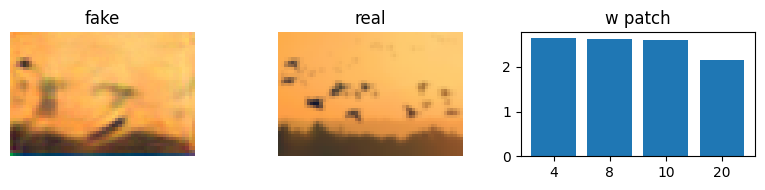

it scale 5:  39%|███▊      | 1003/2600 [00:16<00:35, 45.45it/s]

patch weights : [2.6365 2.6237 2.5871 2.1527]


it scale 5:  77%|███████▋  | 1996/2600 [00:33<00:10, 59.33it/s]

[scale 5 | it 2000] 
[scale 5 | it 2000]  σ = 2.649e-02

 mean lost 100 iter 0.3387

ratio_loss = 32436597.3473


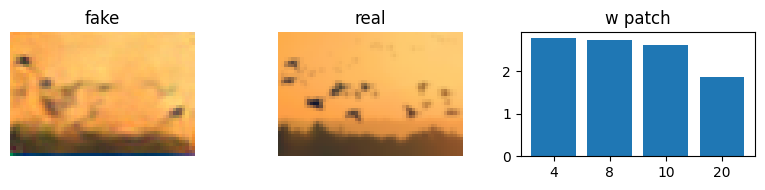

it scale 5:  77%|███████▋  | 2002/2600 [00:34<00:14, 41.30it/s]

patch weights : [2.772  2.7377 2.6236 1.8667]


it scale 5: 100%|█████████▉| 2595/2600 [00:44<00:00, 53.08it/s]

[scale 5 | it 2599] 
[scale 5 | it 2599]  σ = 2.521e-02

 mean lost 100 iter 0.3228

ratio_loss = 29724302.8879


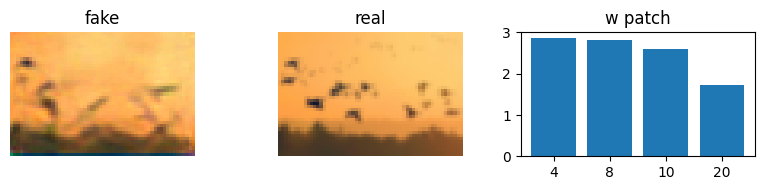

patch weights : [2.8602 2.8079 2.611  1.7209]
STOOPING 


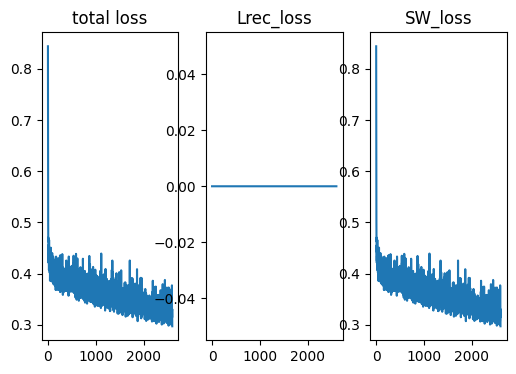

[4, 8, 10, 20] [2, 4, 5, 10]


it scale 4:   0%|          | 0/2900 [00:00<?, ?it/s]

[scale 4 | it 0] 
[scale 4 | it 0]  σ = 2.897e-02

 mean lost 100 iter 1.1298

ratio_loss = 112983870.5063


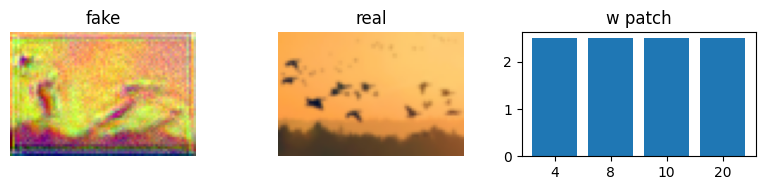

it scale 4:   0%|          | 1/2900 [00:00<07:35,  6.36it/s]

patch weights : [2.5 2.5 2.5 2.5]


it scale 4:  31%|███       | 906/2900 [00:16<00:34, 57.40it/s]

In [ ]:
torch.random.manual_seed(1)

# params
lr             = 1e-4 # celui du github
betas            = (0.5, 0.999) # pareil
base_iter   = 2000 # github
alpha_rec      = 0 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1  # batch size   
lamda_swd = 10

for G in Genarators:
    G.apply(weights_init)

C_swd = lamda_swd                    # on garde la même échelle qu’avant
sw_patch_weights = nn.ModuleList([
    SWPatchWeights(len(PATCH_BASE), C=C_swd).to(device)
    for _ in range(N)
])

def sigma_pos(raw):                      # softplus → σ>0
    return F.softplus(raw)

sigma_raw = nn.ParameterList([           # un scalaire par scale
    nn.Parameter(torch.zeros((), device=device)) 
    for _ in range(N)
])


# reset des optim.
optimizer_G = []
for i in range(N):
    params = (list(Genarators[i].parameters())
              + list(sw_patch_weights[i].parameters())
              + [sigma_raw[i]])          
    optimizer_G.append(optim.Adam(params, lr=lr, betas=betas))


scheduler_G = []

step_size   = 20000        # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G in optimizer_G:
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )

z_star   = torch.randn_like(pyramids[0][-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(pyramids[0][-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev_full(k: int, b: int):
    """
    Renvoie prev_img pour l'échelle k (shape = (b, C, Hk, Wk)) :
      • on part d'une image nulle au coarse (N-1) ;
      • on applique tous les G gelés (N-1 … k+1) avec bruit propre à CHAQUE
        élément du batch ;
      • on upsample à la résolution k.
    """
    # ----------- 0. raccourci coarse ---------------------------------------
    if k == N - 1:                       # échelle la plus grossière
        _, C, Hc, Wc = pyramids[0][k].shape   # scales[k] == (1,C,H,W)
        return torch.zeros(b, C, Hc, Wc, device=device)

    # ----------- 1. point de départ (N-1) ----------------------------------
    _, C, Hc, Wc = pyramids[0][-1].shape
    img = torch.zeros(b, C, Hc, Wc, device=device)        # (b,C,Hc,Wc)
    sigma_val = sigma_pos(sigma_raw[N-1]).item() 
    z  = torch.randn_like(img) * sigma_val
    img = Genarators[N - 1](z)                            # (b,C,Hc,Wc)

    # ----------- 2. remontée N-2 … k+1 -------------------------------------
    for s in range(N - 2, k, -1):
        _, _, Hs, Ws = pyramids[0][s].shape

        # upsample vers la taille courante s
        img_up = F.interpolate(img, size=(Hs, Ws),
                               mode='bilinear', align_corners=False)

        # bruit propre à chaque élément du batch
        sigma_val = sigma_pos(sigma_raw[s]).item()        
        z = torch.randn_like(img_up) * sigma_val


        # passage résiduel : G_s(z + img_up) + img_up
        img = Genarators[s](z + img_up) + img_up

    # ----------- 3. dernier upsample vers l'échelle k ----------------------
    _, _, Hk, Wk = pyramids[0][k].shape
    prev_img = F.interpolate(img, size=(Hk, Wk),
                             mode='bilinear', align_corners=False)
    return prev_img 


# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    xk_real = pyramids[0][current_res].to(device)
    
    
    # if current_res < N-1:                          
    #     G_prev = Genarators[current_res + 1]

    #     def same_channels(net_a, net_b):
    #         """return True if first conv out-channels match"""
    #         for m_a, m_b in zip(net_a.modules(), net_b.modules()):
    #             if isinstance(m_a, torch.nn.Conv2d):
    #                 return m_a.out_channels == m_b.out_channels
    #         return False

    #     if same_channels(Gk, G_prev):              
    #         Gk.load_state_dict(G_prev.state_dict(), strict=True)
    #         if debug:
    #             print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    

    # Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
        σ0 = beta_sigma * torch.sqrt(
                F.mse_loss(up_rec, xk_real) /
                F.mse_loss(torch.zeros_like(xk_real), xk_real)
            )
    else:
        σ0 = torch.tensor(1., device=device)

    # convertit σ0 → raw tel que softplus(raw)=σ0
    sigma_raw[current_res].data.copy_(torch.log(torch.exp(σ0) - 1))
    total_loss_list = []
    Lrec_loss_list = []
    Sw_loss_list = []
    # itérations par scale
    iter_per_scale = base_iter + n* 300
    
    Hk, Wk = xk_real.shape[-2:]                       # hauteur & largeur réelles
    patch_size, stride = patch_table_for_scale(current_res)

    print(patch_size,stride)
        
    
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):
        idx = torch.randint(0, 1, (b,))
       

        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res,b)

        Sw_loss = []
        opt_G.zero_grad()
        xk_real = torch.stack([pyramids[i][current_res].squeeze(0) for i in idx]).to(device)
        w_scale            = sw_patch_weights[current_res]()      # <-- NEW, tensor (4,)
        sigma_cur = sigma_pos(sigma_raw[current_res]) 
        z    = torch.randn_like(prev_img) * sigma_cur
        fake = Gk(z + prev_img) + prev_img

        # ------------------------------------------------------------------
        #  Boucle sur les différentes tailles de patch
        # ------------------------------------------------------------------
        for k, (ps, s) in enumerate(zip(patch_size, stride)):
            real_patches_flat = extract_patches_batched(xk_real, ps, s)
            fake_patches_flat = extract_patches_batched(fake,     ps, s)

            swd = sliced_wasserstein_distance(
                real_patches_flat, fake_patches_flat, num_projections=500
            )
            Sw_loss.append(w_scale[k] * swd)   # <-- NEW : poids apprenable
                    
        # ----- Reconstruction eq. 5 -----
        if current_res == N-1:                         # coarse
            rec_in = z_star.repeat(b,1,1,1)                             # MOD (z_star)
            rec_out = Gk(rec_in)                       # pas de upsample
        else:                                          # n < N
            up_fixed = F.interpolate(x_rec[current_res+1],
                                        size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            up_fixed = up_fixed.repeat(b,1,1,1)
            rec_in = up_fixed                          # MOD (bruit = 0)
            rec_out = Gk(rec_in) + up_fixed            # MOD

        Lrec_loss = alpha_rec * F.mse_loss(rec_out, xk_real)
        total_loss = Lrec_loss + sum(Sw_loss)
        (total_loss).backward()
        
        # for n, p in Gk.named_parameters():
        #     if p.grad is None:
        #         print(f"[grad 😱] {n}   ->   None")

        total_loss_list.append(total_loss.item())
        Lrec_loss_list.append(Lrec_loss.item())
        Sw_loss_list.append(sum(Sw_loss).item())
        opt_G.step()
    
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 1000 == 0 or it==iter_per_scale-1):
            ratio_loss = abs(sum(Sw_loss).item())/(abs(Lrec_loss.item()) + 1e-8)

            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            print(f"[scale {current_res} | it {it}] ")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  σ = {sigma_pos(sigma_raw[current_res]).item():.3e}")
            print(f'\n mean lost 100 iter {np.mean(total_loss_list[-100:]):.4f}')
            print(f"\nratio_loss = {ratio_loss:.4f}")
            
            
            with torch.no_grad():
                w_np = w_scale.detach().cpu().numpy()            # ← valeurs courantes

                plt.figure(figsize=(8,2))                        # + large pour 3 subplots
                # --- fake ---
                plt.subplot(1,3,1)
                plt.imshow(pil_from_minus1to1(fake[0].cpu()))
                plt.axis('off'); plt.title('fake')

                # --- real ---
                plt.subplot(1,3,2)
                plt.imshow(pil_from_minus1to1(xk_real[0].cpu()))
                plt.axis('off'); plt.title('real')

                # --- NEW : poids patch ---
                plt.subplot(1,3,3)
                plt.bar(range(len(w_np)), w_np)
                plt.xticks(range(len(w_np)), [str(ps) for ps in patch_size])
                plt.title('w patch')
                plt.tight_layout()
                plt.show()

                # et un petit print pour les logs texte
                print("patch weights :", np.round(w_np, 4))
    
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        print( "STOOPING ")
        gen_image.append(fake[0].detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star).repeat(b,1,1,1)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)
    plt.figure(figsize=(6,4))
        
    plt.subplot(1,3,1)
    plt.plot(total_loss_list)
    plt.title("total loss")
    plt.subplot(1,3,2)
    plt.plot(Lrec_loss_list)
    plt.title("Lrec_loss")
    plt.subplot(1,3,3)
    plt.plot(Sw_loss_list)
    plt.title("SW_loss")

    plt.show()

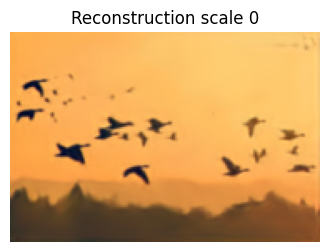

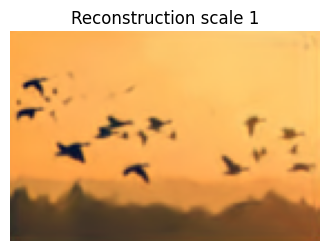

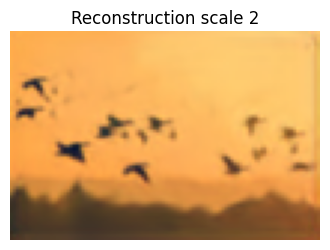

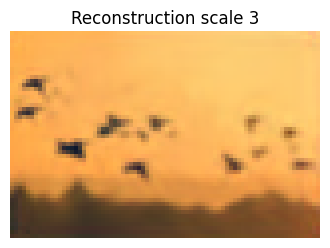

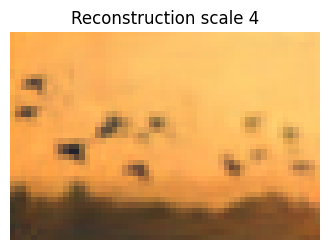

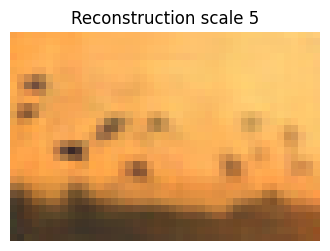

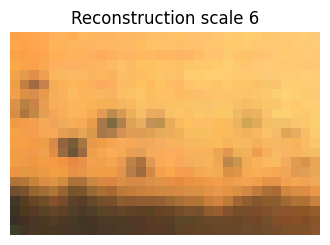

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:])

SAVING GENERATORS AND NECESSARY PARAMS

In [12]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "sw_patch_big_3 "
image_name = "oiseau"                   
model_dir  = os.path.join("models", image_name,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")    # ← chemin pour z_star

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "r"                 : float(4/3),
        "lr"             : lr,
        "betas"          : betas,
        "patch_size": [10,20],
        "n_Generator"    : n_Generator,
        "base_iter" : base_iter,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "lambda_sw" : lamda_swd,
        "stride" : [5,10],
        "comment"        : "Sin Gan avec de la data aug sur l'image réele. + swd trainning on multiple patch_size",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    # 3) sauvegarde de la liste sigma_n
    sigma_list = []
    for s in sigma_n:
        # si s est un tensor scalaire, on fait s.item(), sinon on lève une erreur
        if torch.is_tensor(s):
            sigma_list.append(s.item())
        else:
            sigma_list.append(float(s))
    with open(sigma_fp, "w", encoding="utf-8") as f:
        json.dump(sigma_list, f)


    # 4) génération et sauvegarde de z_star
    #    remplace (h, w) par la forme souhaitée
    torch.save(z_star, zstar_fp)

    print(f"Générateurs sauvegardés     -> {weights_fp}")
    print(f"Description créée           -> {descr_fp}")
    print(f"sigma_n sauvegardé          -> {sigma_fp}")
    print(f"z_star sauvegardé           -> {zstar_fp}")


ATTENTION : Un modèle nommé 'sw_patch_big_2' existe déjà dans 'models/oiseau/sw_patch_big_2'.
   → Choisis un autre nom pour ne pas l'écraser.
